In [1]:
import numpy as np

In [2]:
%matplotlib inline
import os
import sys
from datetime import datetime
import logging
logging.basicConfig(format='%(asctime)s %(message)s', stream=sys.stdout)

import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm_notebook as tqdm

from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
class Log():
    def __init__(self):
        pass
    
    def print(self, msg):
        print(f'{datetime.now().strftime("%H:%M:%S")} {msg}')
        
L = Log()

In [4]:
def read_dataset(model: str, task: str, split: str,  basepath='/scratch/fl1092/ml_protein_data'):
    if model == 'transformer' and split == 'test': split='test_fold_holdout'
    path_to_file = f'{basepath}/{model}/{task}/{task}_{split}.p'
    data = np.load(path_to_file, allow_pickle=True)
    
    return data

def dict_2_arr(data_dict, labels, avgr=lambda x: np.mean(x, axis=0)):
    
    emb_shape = list(data_dict.values())[0].shape
    number_of_embeddings = len(data_dict) 

    X = np.zeros((number_of_embeddings, emb_shape[-1]))
    y = np.zeros(number_of_embeddings)
    
    i = 0

    # iter over sorted keys in labels to ensure proteins
    # from different models are indexed the same
    keys = list(labels.keys())
    keys.sort()
    for key in keys :
        if key in data_dict:
            X[i] = avgr(data_dict[key])
            y[i] = labels[key]
            i += 1
        
    return X, y

def ensemble_append_mean_reps(dicts, labels, LEN, average=True, normalize=True):
    # if average set to False, output 2d arrays for each sequence without averaging
    if LEN == -1:
        LEN = float('inf')
        
    keys = set(dicts[0].keys())
    for i in range(1, len(dicts)):
        keys = keys.intersection(set(dicts[i].keys()))
    
    # combine two dictionary into one by concatenating
    new_dict = dict()
    for key in keys:
        seqs = []
        for d in dicts:
            
            # 1d or 2d
            if average:
                seq = np.mean(d[key], axis=0)
            else:
                seq = d[key]
                if seq.shape[0] < LEN:
                    seq = np.concatenate([seq, np.zeros((LEN-seq.shape[0], seq.shape[1]))], axis=0)
                elif seq.shape[0] > LEN:
                    seq = seq[:LEN, ]
                
            # normalize or not
            if normalize:
                seq = preprocessing.normalize(seq.reshape(1, -1), norm='l2')

            seqs.append(seq)
        combined_seqs = np.concatenate(seqs, axis=-1)
        
        if average:
            combined_seqs[0]
        
        new_dict[key] = combined_seqs
    
    emb_size = combined_seqs.shape
    
    if average:
        X = np.zeros((len(new_dict), emb_size[1]))
    else:
        d1, d2 = emb_size
        X = np.zeros((len(new_dict), d1, d2))
    y = np.zeros(len(new_dict))
    
    i = 0
    for key in new_dict:
        X[i] = new_dict[key]
        y[i] = labels[key]
        i += 1
        
    print('concatenated embedding size: ', X.shape)
        
    return X, y

In [12]:
from tqdm import tqdm_notebook as tqdm

In [19]:
for split in ['train', 'test']:
    labels = read_dataset('label', 'remote_homology', split)
    
    for model in ['elmo','unirep','transformer']:
        data = read_dataset(model, 'remote_homology', split)
        
        for key in tqdm(labels.keys()):
            if key in data:
                with open(f'/scratch/fl1092/ml_protein_data/{model}/{split}__{key}.npy', 'wb') as f:
                    np.save(f, data[key])

In [15]:
lens = []

for split in ['train', 'test']:
    labels = read_dataset('label', 'remote_homology', split)
    
    for model in ['elmo','unirep','transformer']:
        data = read_dataset(model, 'remote_homology', split)
        
        for key in tqdm(labels.keys()):
            if key in data:
                lens.append(data[key].shape[0])

In [16]:
from matplotlib import pyplot as plt

(array([11183., 15519.,  6405.,  3549.,  1452.,   540.,   256.,   100.,
           35.,    30.]),
 array([ 17. , 101.5, 186. , 270.5, 355. , 439.5, 524. , 608.5, 693. ,
        777.5, 862. ]),
 <a list of 10 Patch objects>)

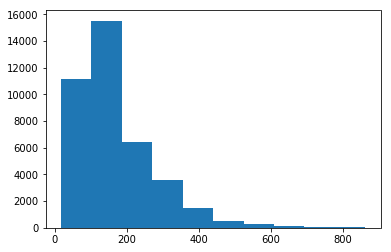

In [17]:
plt.hist(lens)

In [25]:
np.percentile(np.array(lens), 99)

529.0

In [26]:
np.percentile(np.array(lens), 95)

374.0

In [27]:
np.percentile(np.array(lens), 90)

312.0

In [28]:
np.percentile(np.array(lens), 85)

272.0

In [29]:
np.percentile(np.array(lens), 80)

242.0